In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 573kB 5.8MB/s 
     |████████████████████████████████| 3.7MB 15.6MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
     |████████████████████████████████| 1.0MB 39.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=35f55d19baf87c51ff344323c9d034e150da1edce710f459e5876087a4c262a5
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df1 = pd.read_csv("/content/drive/Shared drives/SI630 HW5/data/classification/train.tsv", delimiter='\t', header=None, names=['label', 'text'])

df2 = pd.read_csv("/content/drive/Shared drives/SI630 HW5/data/classification/dev.tsv", delimiter='\t', header=None, names=['label', 'text'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df2.shape[0]))

# Display 10 random rows from the data.
df1.sample(10)

Number of training sentences: 13,902



,label,text
99687,machine,the film is about small time crimes. they take...
18517,human,"con-man insurance salesman mickey, dangerously..."
66425,machine,"junbao mei and doda mari live in buenos aires,..."
82417,machine,"at 1958, dr. norman woodcock is approached by ..."
23949,human,the play opens with the main characters lisa a...
84143,machine,"into her twenties, a devout 30 - year - old mo..."
88523,machine,a group of journalists and sergeants witness t...
22730,human,"5 little hops, by dwane p. jovinson iv dwong d..."
72559,machine,what is it that became known to you : the rose...
91452,machine,"* ilike isbn 00703335, hand : https : // i.la...."


In [ ]:
# Get the lists of sentences and their labels.
sentences1 = df1.text.values
labels1 = df1.label.values
sentences2 = df2.text.values
labels2 = df2.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences1[1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences1[1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences1[1])))

 Original:  once upon a time in the southern chinese city of guancheng, there lived four families, each of them faithful keepers of martial arts. anyone who wanted to establish a new sect, or
Tokenized:  ['once', 'upon', 'a', 'time', 'in', 'the', 'southern', 'chinese', 'city', 'of', 'gu', '##an', '##cheng', ',', 'there', 'lived', 'four', 'families', ',', 'each', 'of', 'them', 'faithful', 'keepers', 'of', 'martial', 'arts', '.', 'anyone', 'who', 'wanted', 'to', 'establish', 'a', 'new', 'sect', ',', 'or']
Token IDs:  [2320, 2588, 1037, 2051, 1999, 1996, 2670, 2822, 2103, 1997, 19739, 2319, 21043, 1010, 2045, 2973, 2176, 2945, 1010, 2169, 1997, 2068, 11633, 24018, 1997, 7761, 2840, 1012, 3087, 2040, 2359, 2000, 5323, 1037, 2047, 17831, 1010, 2030]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences1:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids1 = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids1))

print('Max sentence length: ', max_len)



Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2000 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Max sentence length:  2995


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences2:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids2 = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids2))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (2095 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1011 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1276 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Max sentence length:  2097


Just in case there are some longer test sentences, I'll set the maximum length to 64.


In [ ]:
label1=[]
for i in range(len(labels1)):
      if labels1[i]=='machine':
        label1.append(0)
      else:
        label1.append(1)
print()
print(len(label1))


110559


In [ ]:
label2=[]
for i in range(len(labels2)):
      if labels2[i]=='machine':
        label2.append(0)
      else:
        label2.append(1)
print()
print(len(label2))


13902


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids1= []
attention_masks1 = []

# For every sentence...
for sent in sentences1:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids1.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks1.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids1 = torch.cat(input_ids1, dim=0)
attention_masks1 = torch.cat(attention_masks1, dim=0)
labels1 = torch.tensor(label1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences1[1])
print('Token IDs:', input_ids1[1])

Original:  once upon a time in the southern chinese city of guancheng, there lived four families, each of them faithful keepers of martial arts. anyone who wanted to establish a new sect, or
Token IDs: tensor([  101,  2320,  2588,  1037,  2051,  1999,  1996,  2670,  2822,  2103,
         1997, 19739,  2319, 21043,  1010,  2045,  2973,  2176,  2945,  1010,
         2169,  1997,  2068, 11633, 24018,  1997,  7761,  2840,  1012,  3087,
         2040,   102])


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids2 = []
attention_masks2 = []

# For every sentence...
for sent in sentences2:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids2.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks2.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids2 = torch.cat(input_ids2, dim=0)
attention_masks2 = torch.cat(attention_masks2, dim=0)
labels2 = torch.tensor(label2)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences2[1])
print('Token IDs:', input_ids2[1])

Original:  i continued pleading with my parents to cancel our flight to bangladesh or at least leave me at home. the last time i visited bangladesh, i was 6. i remembered getting sick
Token IDs: tensor([  101,  1045,  2506, 16418,  2007,  2026,  3008,  2000, 17542,  2256,
         3462,  2000,  7269,  2030,  2012,  2560,  2681,  2033,  2012,  2188,
         1012,  1996,  2197,  2051,  1045,  4716,  7269,  1010,  1045,  2001,
         1020,   102])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids1, attention_masks1, labels1)
val_dataset = TensorDataset(input_ids2, attention_masks2, labels2)
# Create a 90-10 train-validation split.

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of  3,455.    Elapsed: 0:00:06.
  Batch    80  of  3,455.    Elapsed: 0:00:12.
  Batch   120  of  3,455.    Elapsed: 0:00:17.
  Batch   160  of  3,455.    Elapsed: 0:00:23.
  Batch   200  of  3,455.    Elapsed: 0:00:29.
  Batch   240  of  3,455.    Elapsed: 0:00:34.
  Batch   280  of  3,455.    Elapsed: 0:00:40.
  Batch   320  of  3,455.    Elapsed: 0:00:46.
  Batch   360  of  3,455.    Elapsed: 0:00:52.
  Batch   400  of  3,455.    Elapsed: 0:00:57.
  Batch   440  of  3,455.    Elapsed: 0:01:03.
  Batch   480  of  3,455.    Elapsed: 0:01:09.
  Batch   520  of  3,455.    Elapsed: 0:01:14.
  Batch   560  of  3,455.    Elapsed: 0:01:20.
  Batch   600  of  3,455.    Elapsed: 0:01:26.
  Batch   640  of  3,455.    Elapsed: 0:01:31.
  Batch   680  of  3,455.    Elapsed: 0:01:37.
  Batch   720  of  3,455.    Elapsed: 0:01:43.
  Batch   760  of  3,455.    Elapsed: 0:01:48.
  Batch   800  of  3,455.    Elapsed: 0:01:54.
  Batch   840  of  3,455.    Elapsed: 0:02:00.
  Batch   880

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.16,0.30,0.86,0:08:10,0:00:14
2,0.07,0.21,0.93,0:08:07,0:00:14


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


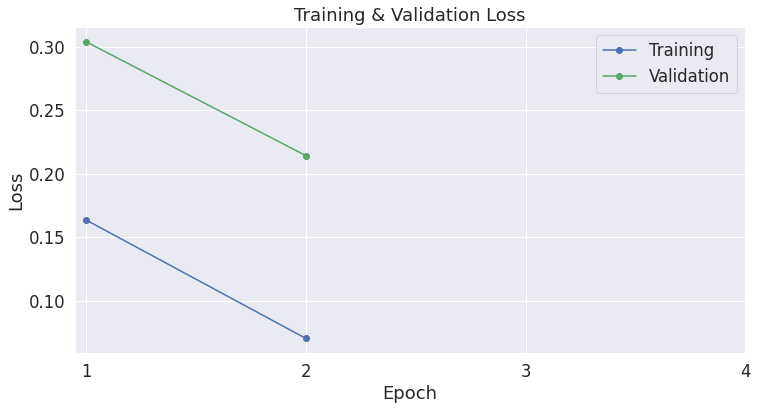

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df= pd.read_csv("/content/drive/Shared drives/SI630 HW5/data/classification/test.tsv", delimiter='\t', header=None, names=['label', 'text'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.label.values
print(len(labels))
label=[]
for i in range(len(labels)):
      if labels[i]=='machine':
        label.append(0)
      else:
        label.append(1)
print()
print(len(label))

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 13,974

13974

13974


In [ ]:
# Prediction on test set
total_eval_accuracy=0
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  # Calculate the accuracy for this batch of test sentences, an
  # accumulate it over all batches.
  total_eval_accuracy += flat_accuracy(logits, label_ids)
  # Report the final accuracy for this validation run.
avg_test_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

print('    DONE.')

Predicting labels for 13,974 test sentences...
  Accuracy: 0.74
    DONE.


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

print('    DONE.')

Predicting labels for 13,974 test sentences...
    DONE.


In [ ]:
f = open("NB.csv", "w")
f.write('Id,Category\n')
for i in range(len(y_predict_test)):   
    f.write(str(i)+','+str(int(y_test[i]))+'\n')
f.close()

In [ ]:
# import pandas as pd

# # Load the dataset into a pandas dataframe.
# df= pd.read_csv("/content/drive/Shared drives/SI630 HW5/Book2.csv", delimiter=',', header=None, names=['label', 'text'])

# # Report the number of sentences.
# print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
# sentences = df.text.values
# labels = df.label.values


# label=[]
# for i in range(len(labels)):
#       if labels[i]=='machine':
#         label.append(0)
#       else:
#         label.append(1)

# print(len(label))

# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []
# attention_masks = []

# # For every sentence...
# for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.

#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 32,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(label)

# # Set the batch size.  
# batch_size = 32  

# # Create the DataLoader.
# prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 10

10


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set
total_eval_accuracy=0
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  # Calculate the accuracy for this batch of test sentences, an
  # accumulate it over all batches.
  total_eval_accuracy += flat_accuracy(logits, label_ids)
  # Report the final accuracy for this validation run.
avg_test_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

print('    DONE.')

Predicting labels for 10 test sentences...
  Accuracy: 0.20
    DONE.


In [ ]:
kaggle_data = read_data("/content/drive/Shared drives/SI630 HW5/data/classification/test.tsv")
kaggle_sentences = np.copy(kaggle_data['Text'].to_numpy())

# Tokenize all of the sentences and map the tokens to thier word IDs.
kaggle_input_ids = []
kaggle_attention_masks = []

# For every sentence...
for sent in kaggle_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    kaggle_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    kaggle_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
kaggle_input_ids = torch.cat(kaggle_input_ids, dim=0)
kaggle_attention_masks = torch.cat(kaggle_attention_masks, dim=0)
kaggle_labels = torch.tensor(np.zeros(13000))

# Print sentence 0, now as a list of IDs.
print('Original: ', kaggle_sentences[0])
print('Token IDs:', kaggle_input_ids[0])

kaggle_dataset = TensorDataset(kaggle_input_ids, kaggle_attention_masks, kaggle_labels)
print('{:>5,} test samples'.format(len(kaggle_dataset)))
kaggle_sampler = SequentialSampler(kaggle_dataset)
kaggle_dataloader = DataLoader(kaggle_dataset, sampler=kaggle_sampler, batch_size=batch_size)

KeyError: ignored

In [ ]:
import pandas as pd

def read_data(filename):
    with open(filename) as f:
        data = {}
        headers = f.readline().strip().split("\t")
        for h in headers:
            data[h] = []
        line = f.readline()
        while line:
            pos = line.find("\t")
            data[headers[0]].append(line[:pos])
            data[headers[1]].append(line[pos+1:-1])
            line = f.readline()
    return pd.DataFrame(data)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(kaggle_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in kaggle_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

print('    DONE.')

NameError: ignored

In [ ]:
import csv

predictions = np.array(predictions)

with open("/content/gdrive/My Drive/SI630/hw5_part2_results.csv", "w", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Id", "Category"])
        for i, output in enumerate(predictions):
            if output[0] > output[1]:
                writer.writerow([i, "machine"])
            else:
                writer.writerow([i, "human"])